In [ ]:
pip install Sastrawi

In [ ]:
import csv
import numpy as np

In [ ]:
import pandas as pd

df = pd.read_csv("/content/dataset.csv", nrows=700)
df

,Id,Sentiment,Pasangan Calon,Text Tweet
0,1,negative,Agus-Sylvi,Banyak akun kloning seolah2 pendukung #agussil...
1,2,negative,Agus-Sylvi,#agussilvy bicara apa kasihan yaa...lap itu ai...
2,3,negative,Agus-Sylvi,Kalau aku sih gak nunggu hasil akhir QC tp lag...
3,4,negative,Agus-Sylvi,Kasian oh kasian dengan peluru 1milyar untuk t...
4,5,negative,Agus-Sylvi,Maaf ya pendukung #AgusSilvy..hayo dukung #Ani...
...,...,...,...,...
695,696,negative,Anies-Sandi,Hari ini bhineka tunggal ika tidak akan berlak...
696,697,negative,Anies-Sandi,Tadinya saya suka baca @okezonenews tapi isin...
697,698,negative,Anies-Sandi,Bagian 1 .. Bukti Radikalis Pendukung Teroris ...
698,699,negative,Anies-Sandi,"Cuma kota Jakarta, PKS di Papua malah berkoali..."


In [ ]:
df.shape

(700, 4)

In [ ]:
df.Sentiment.value_counts()

negative    400
positive    300
Name: Sentiment, dtype: int64

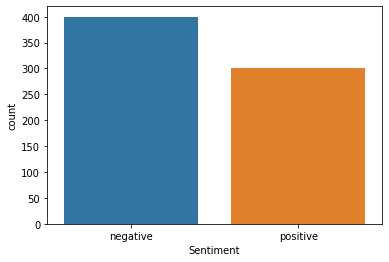

In [ ]:
import seaborn as sns
sns.countplot(x='Sentiment', data=df)

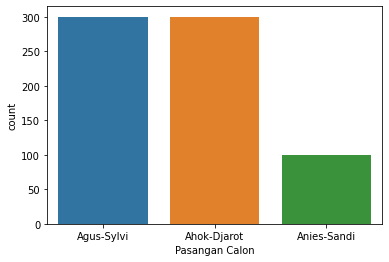

In [ ]:
sns.countplot(x='Pasangan Calon', data=df)

In [ ]:
tweet = df['Text Tweet']
sentimen = df['Sentiment']

Preprocessing

In [ ]:
import nltk
nltk.download("stopwords")
import re
import Sastrawi
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def stopword(stopwordsfile):
    stopwords=[]
    file_stopwords = open(stopwordsfile,'r')
    row = file_stopwords.readline()
    while row:
        word = row.strip()
        stopwords.append(word)
        row = file_stopwords.readline()
    file_stopwords.close()
    return stopwords

In [ ]:
stopwords_indo = stopword('stopwords.txt')

In [ ]:
# Case Folding
%%time
X_lower = tweet.str.lower() #lowercase
X_num = X_lower.apply(lambda x: re.sub(r"\d+", "", str(x))) #delete numbers
X_sign = X_num.apply(lambda x: re.sub(r'\W', ' ', str(x))) #punctuation

CPU times: user 12.6 ms, sys: 1.09 ms, total: 13.6 ms
Wall time: 15.6 ms


In [ ]:
# Tokenization
%%time
tweet_tokenizer = TweetTokenizer()
tweet_tokens = X_sign.apply(lambda x: tweet_tokenizer.tokenize(x))

CPU times: user 40 ms, sys: 2.12 ms, total: 42.2 ms
Wall time: 43.1 ms


In [ ]:
# Stopwords Removal
%%time
tokens = tweet_tokens.apply(lambda x: [w for w in x if w not in stopwords_indo])

CPU times: user 93.1 ms, sys: 1.04 ms, total: 94.1 ms
Wall time: 95.5 ms


Split dataset

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(tokens,sentimen,test_size=0.2)

Klasifikasi

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import f1_score, make_scorer,accuracy_score, classification_report, confusion_matrix
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from sklearn.pipeline import Pipeline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
def identity_tokenizer(text):
    return text
    
text_clf = Pipeline([('vect', TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False)),
                     ('clf', MultinomialNB()),
                     ])
tuned_parameters = {
    'vect__min_df': [5,6,7,8,9,10], 
    'vect__max_df': [0.25, 0.5, 0.75], 
    'vect__sublinear_tf': [True, False], 
    'vect__smooth_idf': [True, False],
    'vect__use_idf': [True, False], 
    'vect__analyzer': ['word', 'char', 'char_wb'], 
    'vect__norm': ['l1','l2'],
    'vect__ngram_range' : [(1, 1), (1, 2), (1, 3), (1,4), (1, 5),(1, 6)],
    'vect__use_idf': (True, False),
    'vect__norm': ('l1', 'l2'),
    'clf__alpha': np.linspace(0.5, 1.5, 6),
    'clf__fit_prior': [True, False],  
}

NB Classifier

In [ ]:
%%time
pipe = make_pipeline_imb(TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False),
                         TfidfTransformer(),MultinomialNB())

pipe.fit(X_train, y_train)
y_pred_NB = pipe.predict(X_test)
results = confusion_matrix(y_test, y_pred_NB) 
print('Confusion Matrix:')
print(results)
print('Report:')
report = classification_report(y_test, y_pred_NB, digits=4)
print(report)

Confusion Matrix:
[[70  7]
 [26 37]]
Report:
              precision    recall  f1-score   support

    negative     0.7292    0.9091    0.8092        77
    positive     0.8409    0.5873    0.6916        63

    accuracy                         0.7643       140
   macro avg     0.7850    0.7482    0.7504       140
weighted avg     0.7795    0.7643    0.7563       140

CPU times: user 28.4 ms, sys: 2.05 ms, total: 30.4 ms
Wall time: 30.4 ms


In [ ]:
result_class = pd.DataFrame({
    'Actual Result': y_test,
    'Naive Bayes': y_pred_NB,
})
result_class

,Actual Result,Naive Bayes
299,positive,negative
475,positive,positive
145,negative,negative
663,negative,positive
686,negative,negative
...,...,...
318,negative,negative
308,negative,negative
322,negative,negative
625,negative,negative


In [ ]:
result_class.to_excel("result_class.xlsx")

In [ ]:
X_train2,X_test2,y_train2,y_test2 = train_test_split(tokens,sentimen,test_size=0.3)

In [ ]:
  %%time
pipe = make_pipeline_imb(TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False),
                         TfidfTransformer(),MultinomialNB())

pipe.fit(X_train2, y_train2)
y_pred_NB2 = pipe.predict(X_test2)
results2 = confusion_matrix(y_test2, y_pred_NB2) 
print('Confusion Matrix:')
print(results2)
print('Report:')
report2 = classification_report(y_test2, y_pred_NB2, digits=4)
print(report2)

Confusion Matrix:
[[107  21]
 [ 21  61]]
Report:
              precision    recall  f1-score   support

    negative     0.8359    0.8359    0.8359       128
    positive     0.7439    0.7439    0.7439        82

    accuracy                         0.8000       210
   macro avg     0.7899    0.7899    0.7899       210
weighted avg     0.8000    0.8000    0.8000       210

CPU times: user 35.2 ms, sys: 144 µs, total: 35.3 ms
Wall time: 38.2 ms


In [ ]:
result_class2 = pd.DataFrame({
    'Actual Result': y_test2,
    'Naive Bayes': y_pred_NB2,
})
result_class2

,Actual Result,Naive Bayes
20,negative,negative
101,negative,negative
62,negative,negative
77,negative,negative
151,positive,positive
...,...,...
371,negative,negative
446,negative,negative
80,negative,negative
82,negative,positive


In [ ]:
result_class2.to_excel("result_class2.xlsx")